In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
def truncate_column_name(name, max_length=10):
    """
    Обрезает название столбца до максимальной длины
    """
    if len(str(name)) <= max_length:
        return str(name)
    return str(name)[:max_length-3] + "..."

def plot_boxplots(df):
    """
    Выводит boxplot для всех численных столбцов в DataFrame
    """
    # Выбираем только численные колонки
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    if len(numeric_columns) == 0:
        print("В DataFrame нет численных столбцов")
        return
    
    # Определяем количество строк и столбцов для subplot
    n_cols = 3
    n_rows = (len(numeric_columns) + n_cols - 1) // n_cols
    
    # Создаем grid subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    # Преобразуем axes в плоский массив для единообразной обработки
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flat
    else:
        axes = axes.flatten()
    
    # Строим boxplot для каждого численного столбца
    for i, col in enumerate(numeric_columns):
        if i < len(axes):
            axes[i].boxplot(df[col].dropna())
            truncated_name = truncate_column_name(col)
            axes[i].set_title(f'Boxplot: {truncated_name}')
            axes[i].set_ylabel('Values')
    
    # Убираем лишние subplots
    for i in range(len(numeric_columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_histograms(df):
    """
    Выводит гистограммы для всех столбцов (включая нечисловые)
    """
    # Все колонки
    all_columns = df.columns
    
    if len(all_columns) == 0:
        print("DataFrame пустой")
        return
    
    # Определяем количество строк и столбцов для subplot
    n_cols = 3
    n_rows = (len(all_columns) + n_cols - 1) // n_cols
    
    # Создаем grid subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    # Преобразуем axes в плоский массив для единообразной обработки
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flat
    else:
        axes = axes.flatten()
    
    # Строим гистограммы для каждого столбца
    for i, col in enumerate(all_columns):
        if i < len(axes):
            truncated_name = truncate_column_name(col)
            
            # Для числовых данных
            if pd.api.types.is_numeric_dtype(df[col]):
                axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
                axes[i].set_title(f'Histogram: {truncated_name}')
                axes[i].set_xlabel('Values')
                axes[i].set_ylabel('Frequency')
            # Для категориальных данных
            else:
                value_counts = df[col].value_counts().head(10)  # Берем топ-10 значений
                
                # Обрезаем имена категорий для подписей на оси X
                truncated_labels = [truncate_column_name(str(label)) for label in value_counts.index]
                
                axes[i].bar(range(len(truncated_labels)), value_counts.values)
                axes[i].set_title(f'Bar chart: {truncated_name}')
                axes[i].set_xlabel('Categories')
                axes[i].set_ylabel('Count')
                axes[i].set_xticks(range(len(truncated_labels)))
                axes[i].set_xticklabels(truncated_labels, rotation=45, ha='right')
    
    # Убираем лишние subplots
    for i in range(len(all_columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_cluster_model(df, n_clusters=3, random_state=42):
    """
    Создает модель кластеризации и визуализирует результат в 2D
    """
    # Выбираем только численные колонки и удаляем пропуски
    numeric_df = df.select_dtypes(include=[np.number]).dropna()
    
    if len(numeric_df) == 0:
        print("Нет данных для кластеризации")
        return None, None
    
    if len(numeric_df) < n_clusters:
        print(f"Недостаточно данных для {n_clusters} кластеров")
        return None, None
    
    # Стандартизируем данные
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)
    
    # Создаем модель кластеризации K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(scaled_data)
    
    # Уменьшаем размерность до 2D с помощью PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Создаем график
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], 
                         c=clusters, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'K-means Clustering (n_clusters={n_clusters})')
    plt.grid(True, alpha=0.3)
    
    # Добавляем центроиды кластеров
    centroids = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, 0], centroids[:, 1], 
               marker='X', s=200, c='red', label='Centroids')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Выводим информацию о кластерах
    cluster_info = pd.DataFrame({
        'cluster': range(n_clusters),
        'size': [sum(clusters == i) for i in range(n_clusters)]
    })
    print("Информация о кластерах:")
    print(cluster_info)
    
    return kmeans, pca

In [3]:
df_items = pd.read_csv("dataset\\KION_DATASET\\data_en\\items_en.csv")
df_items = df_items.drop('Unnamed: 0', axis=1)
df_items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,description,keywords,actors_translated,actors_transliterated,directors_translated,transliterated
0,10711,film,Talk to her,Hable con ella,2002.0,"drama, foreign, detective, melodrama",Spain,NaN,16.0,NaN,"Marco, a journalist, interviews the famous Tor...","Talk, her, 2002, Spain, friends, love, strong,...","Adolfo Fernández, Ana Fernández, Dario Grandin...","Adol'fo Fernandes, Ana Fernandes, Dario Grandi...",Pedro Almodovar,Pedro Al'modovar
1,2508,film,Naked Peppers,Search Party,2014.0,"foreign, adventure, comedy",USA,NaN,16.0,NaN,The main character has learned not to invite h...,"Naked, Peppers, 2014, USA, friends, weddings, ...","Adam Palley, Brian Huskey, JB Smoove, Jason Ma...","Adam Palli, Brajan Haski, Dzh.B. Smuv, Dzhejso...",Scott Armstrong,Skot Armstrong
2,10716,film,Tactical force,Tactical Force,2011.0,"crime, foreign, thrillers, action, comedy",Canada,NaN,16.0,NaN,"Professional wrestler Steve Austin (""All or No...","Tactical, Force, 2011, Canada, bandits, gangst...","Adrian Holmes, Darren Shalavi, Jerry Wasserman...","Adrian Holms, Darren Shalavi, Dzherri Vasserma...",Adam P. Caltraro,Adam P. Kaltraro
3,7868,film,45 years old,45 Years,2015.0,"drama, foreign, melodrama",UK,NaN,16.0,NaN,"Charlotte Rampling, Tom Courtney, Geraldine Ja...","45, years, 2015, United Kingdom, marriage, lif...","Alexandra Riddleston-Barrett, Geraldine James,...","Aleksandra Riddlston-Barrett, Dzheral'din Dzhe...",By Andrew Hay,Endrju Hej
4,16268,film,Everything Solves in a Moment,NaN,1978.0,"drama, sport, soviet, melodrama",USSR,NaN,12.0,Lenfilm,The circle of her mentors and the most loyal f...,"Everything that decides, moment, 1978, USSR, s...","Aleksandr Abdulov, Aleksandr Demyanenko, Alexe...","Aleksandr Abdulov, Aleksandr Dem'janenko, Alek...",Victor Sadovsky,Viktor Sadovskij


In [4]:
df_users = pd.read_csv("dataset\\KION_DATASET\\data_en\\users_en.csv")
df_users = df_users.drop('Unnamed: 0', axis=1)
df_users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,M,1
1,962099,age_18_24,income_20_40,M,0
2,1047345,age_45_54,income_40_60,F,0
3,721985,age_45_54,income_20_40,F,0
4,704055,age_35_44,income_60_90,F,0


In [5]:
df_interactions = pd.read_csv("dataset\\KION_DATASET\\interactions.csv")
df_interactions['last_watch_dt'] = pd.to_datetime(df_interactions['last_watch_dt'])
df_interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [61]:
def new_metric(recommended_list, watched_list):
    rec = np.array(recommended_list)
    wat = np.array(watched_list)
    inter = wat - rec 
    inter = np.abs(inter)
    return inter.sum() / len(inter)


In [7]:
df_items['genres_parsed'] = df_items['genres'].apply(lambda x: list(str(x).split(',')))
df_items['keywords_parsed'] = df_items['keywords'].apply(lambda x: list(str(x).split(',')))
df_items['actors_translated_parsed'] = df_items['actors_translated'].apply(lambda x: list(str(x).split(',')))
df_items['directors_translated_parsed'] = df_items['directors_translated'].apply(lambda x: list(str(x).split(',')))

In [8]:
test_size_weeks = 3
df_interactions_test = df_interactions[df_interactions['last_watch_dt'].max() - df_interactions['last_watch_dt'] < np.timedelta64(21) ]
df_interactions_train = df_interactions[df_interactions['last_watch_dt'].max() - df_interactions['last_watch_dt'] >= np.timedelta64(21) ]
df_interactions_test = df_interactions_test.groupby('item_id').filter(lambda group: len(group) > 2)
df_interactions_train = df_interactions_train.groupby('item_id').filter(lambda group: len(group) > 2)
# common_item_ids = df_interactions_test['item_id'].isin(df_interactions_train['item_id'])
# common_item_ids = common_item_ids[common_item_ids].index
# df_interactions_test = df_interactions_test[df_interactions_test['item_id'].isin(common_item_ids)]
# df_interactions_train = df_interactions_train[df_interactions_train['item_id'].isin(common_item_ids)]
print(f"length of df_interactions_test: {len(df_interactions_test)}")
print(f"length of df_interactions_train: {len(df_interactions_train)}")

length of df_interactions_test: 18612
length of df_interactions_train: 1568845


In [9]:
# users_with_views = df_interactions_test['user_id'].unique()
users_with_views = df_interactions_test.groupby('user_id').filter(lambda group: len(group) > 2 and len(group) < 20)['user_id'].unique()
all_users = df_users['user_id'].unique()

flags = np.isin(users_with_views, all_users)
users_with_views = users_with_views[flags]

In [10]:
def precision_at_k(recommended_list, watched_list, k=5):
    
    watched_list = np.array(watched_list)
    recommended_list = np.array(recommended_list)
    
    #assert len(watched_list) > len(recommended_list)
    watched_list = watched_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(watched_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

def ap_k(recommended_list, watched_list, k=5):
    """
    Вычисляет Average Precision at k (AP@k)

    Parameters:
    recommended_list (list или np.array): Ранжированный список рекомендаций
    watched_list (list или np.array): Список релевантных (просмотренных) элементов
    k (int): Глубина оценки (по умолчанию 5)

    Returns:
    float: Значение AP@k
    """
    # Если recommended_list двумерный (содержит пары [item_id, weight]), 
    # извлекаем только item_id из первого столбца
    recommended_list = np.array(recommended_list)
    if recommended_list.ndim == 2:
        recommended_list = recommended_list[:, 0]  # Берем только item_id
    
    watched_list = np.array(watched_list)
    recommended_list = recommended_list[:k]  # ✅ Ограничиваем k рекомендациями
    
    # Создаем булев массив совпадений
    flags = np.isin(recommended_list, watched_list)
    
    # Если в рекомендациях нет релевантных элементов, возвращаем 0
    relevant_count = np.sum(flags)
    if relevant_count == 0:
        return 0.0
    
    # Вычисляем AP@k
    sum_precision = 0.0
    for i in range(len(recommended_list)):
        if flags[i]:  # ✅ Теперь flags[i] - скалярное булево значение
            # Precision at k вычисляется для текущей глубины i+1
            p_k = np.sum(flags[:i+1]) / (i+1)
            sum_precision += p_k
    
    # Делим на количество релевантных элементов в топ-k
    ap_result = sum_precision / relevant_count
    
    return ap_result

def map_k(recommended_list, watched_list, k=5, u=1):
    sum_ = 0
    l = min(len(watched_list), u)
    for i in range(l):
        sum_ += ap_k(recommended_list[i], watched_list[i], k)
    result = sum_ / l
    return result

In [11]:
def progress_bar(current, total, bar_length=50, append=""):
    fraction = current / total
    arrow = int(fraction * bar_length - 1) * '=' + '>'
    padding = (bar_length - len(arrow)) * ' '
    
    progress = f'Progress: [{arrow}{padding}] {int(fraction*100)}%\t{current}/{total}' + append
    print(progress, end='\r')
    
    if current == total: 
        print()

In [12]:
def count_avg_MAP_for_recommendation(users_with_views, df_interactions_train, df_interactions_test, df_items, recommend_func, coefs=[0.5,0.5,0.5]):
    map_10 = 0
    l = len(users_with_views)
    for i, user in enumerate(users_with_views):
        progress_bar(i, l)
        watched_previous_list = df_interactions_train[df_interactions_train["user_id"] == user]
        user_info = df_users[df_users['user_id'] == user]
        items = df_items
        recomendations = recommend_func(user_info, watched_previous_list, df_interactions_train, items, count = 10, coefs=coefs)
        map_10 += ap_k(recomendations, df_interactions_test[df_interactions_test['user_id'] == user]['item_id'])

    map_10 /= len(users_with_views)
    return map_10

def stand(users_with_views, df_interactions_train, df_interactions_test, df_items, recommend_func, *args, **kwargs):
    map_10 = 0
    l = len(users_with_views)
    user = users_with_views[0]
    print("\ndf_interactions_train")
    print(df_interactions_train)
    watched_previous_list = df_interactions_train[df_interactions_train["user_id"] == user]
    print("\nwatched_previous_list")
    print(watched_previous_list)
    user_info = df_users[df_users['user_id'] == user]
    print("\nuser_info")
    print(user_info)
    items = df_items
    print("\nitems")
    print(items)
    # recomendations = recommend_func(user_info, watched_previous_list, df_interactions_train, items, count = 10)
    # map_10 += ap_k(recomendations, df_interactions_test[df_interactions_test['user_id'] == user]['item_id'])

    # map_10 /= len(users_with_views)
    # return map_10

In [13]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class ALS:
    def __init__(self, n_factors=10, alpha=40, regularization=0.1, iterations=15):
        """
        Инициализация ALS модели
        
        Parameters:
        - n_factors: количество латентных факторов
        - alpha: параметр уверенности для неявной обратной связи
        - regularization: коэффициент регуляризации (lambda)
        - iterations: количество итераций обучения
        """
        self.n_factors = n_factors
        self.alpha = alpha
        self.regularization = regularization
        self.iterations = iterations
        self.user_factors = None
        self.item_factors = None
        self.loss_history = []
    
    def fit(self, ratings):
        """
        Обучение ALS модели
        
        Parameters:
        - ratings: scipy sparse matrix в формате (users × items)
        """
        n_users, n_items = ratings.shape
        
        # Инициализация матриц факторов
        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors))
        
        print("Начинаем обучение ALS...")
        
        for iteration in range(self.iterations):
            # Шаг 1: Фиксируем item factors, обновляем user factors
            for u in range(n_users):
                # Получаем индексы и значения оценок пользователя
                user_ratings = ratings[u].toarray().flatten()
                rated_items = np.where(user_ratings > 0)[0]
                
                if len(rated_items) > 0:
                    # Вычисляем уверенности для неявной обратной связи
                    confidence = 1 + self.alpha * user_ratings[rated_items]
                    
                    # Матрица item factors для оцененных items
                    Y = self.item_factors[rated_items]
                    
                    # Вычисляем матрицу A и вектор b
                    C = np.diag(confidence)
                    A = Y.T @ C @ Y + self.regularization * np.eye(self.n_factors)
                    b = Y.T @ confidence
                    
                    # Решаем линейную систему
                    self.user_factors[u] = np.linalg.solve(A, b)
            
            # Шаг 2: Фиксируем user factors, обновляем item factors
            for i in range(n_items):
                # Получаем индексы и значения оценок для item
                item_ratings = ratings[:, i].toarray().flatten()
                rating_users = np.where(item_ratings > 0)[0]
                
                if len(rating_users) > 0:
                    # Вычисляем уверенности
                    confidence = 1 + self.alpha * item_ratings[rating_users]
                    
                    # Матрица user factors для оценивших пользователей
                    X = self.user_factors[rating_users]
                    
                    # Вычисляем матрицу A и вектор b
                    C = np.diag(confidence)
                    A = X.T @ C @ X + self.regularization * np.eye(self.n_factors)
                    b = X.T @ confidence
                    
                    # Решаем линейную систему
                    self.item_factors[i] = np.linalg.solve(A, b)
            
            # Вычисляем loss
            loss = self._compute_loss(ratings)
            self.loss_history.append(loss)
            print(f"Итерация {iteration + 1}/{self.iterations}, Loss: {loss:.4f}")
    
    def _compute_loss(self, ratings):
        """Вычисление функции потерь"""
        loss = 0
        n_users, n_items = ratings.shape
        
        for u in range(n_users):
            for i in range(n_items):
                if ratings[u, i] > 0:
                    prediction = self.user_factors[u] @ self.item_factors[i]
                    confidence = 1 + self.alpha * ratings[u, i]
                    error = confidence - prediction
                    loss += error ** 2
        
        # Добавляем регуляризацию
        reg_loss = self.regularization * (
            np.sum(self.user_factors ** 2) + np.sum(self.item_factors ** 2)
        )
        
        return loss + reg_loss
    
    def predict(self, user_id, item_id):
        """Предсказание оценки"""
        return self.user_factors[user_id] @ self.item_factors[item_id]
    
    def recommend(self, user_id, n_recommendations=10):
        """Рекомендации для пользователя"""
        user_vector = self.user_factors[user_id]
        scores = user_vector @ self.item_factors.T
        top_items = np.argsort(scores)[::-1][:n_recommendations]
        return top_items, scores[top_items]
    
    def plot_loss(self):
        """Визуализация истории потерь"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_history, marker='o')
        plt.title('История обучения ALS')
        plt.xlabel('Итерация')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()



In [18]:
from sklearn.preprocessing import LabelEncoder
import scipy.sparse as sp
def create_sparse_interaction_matrix(users_with_views, df_interactions_train, df_items):
    """
    Создает разреженную матрицу взаимодействий пользователь-предмет
    
    Parameters:
    -----------
    users_with_views : list
        Список пользователей для включения в матрицу
    df_interactions_train : pd.DataFrame
        Тренировочные взаимодействия со столбцами ['user_id', 'item_id', 'watched_pct']
    df_items : pd.DataFrame
        Список всех предметов
    
    Returns:
    --------
    sparse_matrix : scipy.sparse.csr_matrix
        Разреженная матрица взаимодействий
    user_encoder : LabelEncoder
        Кодировщик user_id в индексы строк
    item_encoder : LabelEncoder  
        Кодировщик item_id в индексы столбцов
    """
    
    # Фильтруем взаимодействия только для нужных пользователей
    filtered_interactions = df_interactions_train[
        df_interactions_train['user_id'].isin(users_with_views)
    ].copy()
    
    # Создаем кодировщики для пользователей и предметов
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    
    # Подготавливаем всех возможных пользователей и предметы
    all_users = sorted(users_with_views)
    all_items = sorted(df_items['item_id'].unique())
    
    # Обучаем кодировщики
    user_encoder.fit(all_users)
    item_encoder.fit(all_items)
    
    # Преобразуем user_id и item_id в числовые индексы
    user_indices = user_encoder.transform(filtered_interactions['user_id'])
    item_indices = item_encoder.transform(filtered_interactions['item_id'])
    
    def vals(vs):
        return vs/100 if vs>50 else 0
    # Вычисляем значения watched_pct / 100
    values = filtered_interactions['watched_pct'].apply(vals)
    
    # Создаем разреженную матрицу в формате COO
    sparse_matrix = sp.coo_matrix(
        (values, (user_indices, item_indices)),
        shape=(len(all_users), len(all_items))
    )
    
    # Конвертируем в CSR для эффективных операций
    sparse_matrix_csr = sparse_matrix.tocsr()
    
    return sparse_matrix_csr, user_encoder, item_encoder

In [20]:
sparse_matrix_csr, user_encoder, item_encoder = create_sparse_interaction_matrix(users_with_views, df_interactions_train, df_items)
sparse_matrix_csr

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3000 stored elements and shape (377, 15963)>

Начинаем обучение ALS...
Итерация 1/40, Loss: 1629126.0557
Итерация 2/40, Loss: 1628722.8829
Итерация 3/40, Loss: 1628578.5992
Итерация 4/40, Loss: 1628476.2333
Итерация 5/40, Loss: 1628397.8782
Итерация 6/40, Loss: 1628335.2013
Итерация 7/40, Loss: 1628283.4883
Итерация 8/40, Loss: 1628239.7891
Итерация 9/40, Loss: 1628202.1480
Итерация 10/40, Loss: 1628169.2567
Итерация 11/40, Loss: 1628140.1980
Итерация 12/40, Loss: 1628114.2856
Итерация 13/40, Loss: 1628090.9921
Итерация 14/40, Loss: 1628069.9098
Итерация 15/40, Loss: 1628050.7188
Итерация 16/40, Loss: 1628033.1627
Итерация 17/40, Loss: 1628017.0324
Итерация 18/40, Loss: 1628002.1543
Итерация 19/40, Loss: 1627988.3831
Итерация 20/40, Loss: 1627975.5958
Итерация 21/40, Loss: 1627963.6873
Итерация 22/40, Loss: 1627952.5664
Итерация 23/40, Loss: 1627942.1547
Итерация 24/40, Loss: 1627932.3839
Итерация 25/40, Loss: 1627923.1937
Итерация 26/40, Loss: 1627914.5302
Итерация 27/40, Loss: 1627906.3464
Итерация 28/40, Loss: 1627898.6009
Итер

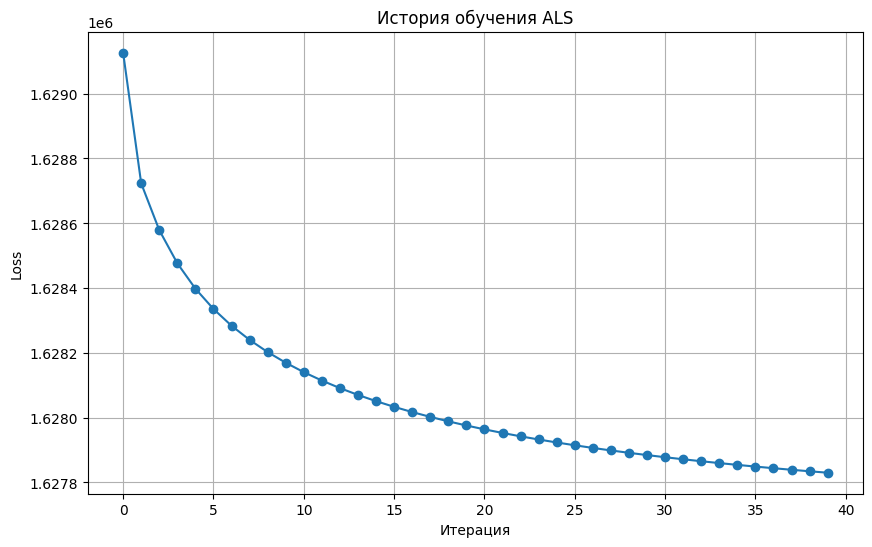

In [22]:
als_model = ALS(
        n_factors=10,
        alpha=40,
        regularization=0.1,
        iterations=40
    )
# Обучение модели
als_model.fit(sparse_matrix_csr)
    
# Визуализация процесса обучения
als_model.plot_loss()

In [23]:
test_data, user_encoder, item_encoder = create_sparse_interaction_matrix(users_with_views, df_interactions_test, df_items)
test_data

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1257 stored elements and shape (377, 15963)>

In [31]:
import pickle
with open("als_model.dump", "wb") as filee:
    pickle.dump(als_model, filee)

In [24]:
test_predictions = []
test_actual = []
    
for u in range(test_data.shape[0]):
    for i in range(test_data.shape[1]):
        if test_data[u, i] > 0:
                pred = als_model.predict(u, i)
                test_predictions.append(pred)
                test_actual.append(test_data[u, i])
    
# Вычисляем метрики
mse = mean_squared_error(test_actual, test_predictions)
rmse = np.sqrt(mse)
    
print(f"RMSE на тестовой выборке: {rmse:.4f}")
    
    # Демонстрация рекомендаций
print("\nДемонстрация рекомендаций:")
user_id = 0
recommended_items, scores = als_model.recommend(user_id, n_recommendations=10)
    
print(f"Топ-10 рекомендаций для пользователя {user_id}:")
for i, (item, score) in enumerate(zip(recommended_items, scores)):
    print(f"{i+1}. Item {item} (score: {score:.3f})")
    
    # Анализ факторов
print(f"\nАнализ модели:")
print(f"Размерность user_factors: {als_model.user_factors.shape}")
print(f"Размерность item_factors: {als_model.item_factors.shape}")
print(f"Общее количество параметров: {als_model.user_factors.size + als_model.item_factors.size}")

RMSE на тестовой выборке: 0.9399

Демонстрация рекомендаций:
Топ-10 рекомендаций для пользователя 0:
1. Item 3599 (score: 0.995)
2. Item 11827 (score: 0.947)
3. Item 8356 (score: 0.938)
4. Item 14030 (score: 0.812)
5. Item 14388 (score: 0.799)
6. Item 4709 (score: 0.799)
7. Item 9040 (score: 0.787)
8. Item 9 (score: 0.758)
9. Item 6618 (score: 0.751)
10. Item 1336 (score: 0.744)

Анализ модели:
Размерность user_factors: (377, 10)
Размерность item_factors: (15963, 10)
Общее количество параметров: 163400


In [35]:
test_predictions, test_actual

([np.float64(0.028086062527688943),
  np.float64(-0.08110849122261991),
  np.float64(1.019273283323442),
  np.float64(0.49961879038727797),
  np.float64(0.2749778724560487),
  np.float64(0.30312510789601893),
  np.float64(1.0813932346379358),
  np.float64(0.15557953081170442),
  np.float64(0.011582096393548028),
  np.float64(0.04029216959316395),
  np.float64(0.015167707846253289),
  np.float64(0.04457570450385826),
  np.float64(0.014665418389511424),
  np.float64(0.015366647317862319),
  np.float64(0.13202508150830472),
  np.float64(-0.01235304815982315),
  np.float64(0.02159846588640507),
  np.float64(0.0034262295453227646),
  np.float64(-0.022540999997608807),
  np.float64(-0.16159440152774412),
  np.float64(0.3751076137180418),
  np.float64(0.008447017769544768),
  np.float64(0.010871295982940829),
  np.float64(-0.009733698470641521),
  np.float64(-0.03307349423129584),
  np.float64(-0.02603924911567006),
  np.float64(0.3364046604208291),
  np.float64(-0.40925246662977577),
  np.fl

In [38]:
mas = np.random.random_integers(1, 25, 20)
print(mas)
mas[np.argsort(mas)[-10:][::-1]]

[ 6  9 15 15 19  4  1  9  9  6 13  7 11  1 11 24 15  6  6 10]


C:\Users\leous\AppData\Local\Temp\ipykernel_43772\2053135334.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 25 + 1) instead
  mas = np.random.random_integers(1, 25, 20)


array([24, 19, 15, 15, 15, 13, 11, 11, 10,  9], dtype=int32)

In [62]:
map_10 = 0

test_predictions = []
test_actual = []
    
for u in range(test_data.shape[0]):
    progress_bar(u, test_data.shape[0])
    for i in range(test_data.shape[1]):
        if test_data[u, i] > 0:
            pred = als_model.predict(u, i)
            test_predictions.append(pred)
            test_actual.append(test_data[u, i])

    test_predictions = np.array(test_predictions)
    test_actual = np.array(test_actual)
    if len(test_actual) != 0:
        map_10 += new_metric(test_predictions, test_actual)
    test_predictions = []
    test_actual = []
        # break

map_10 /= len(users_with_views)
map_10

# test_actual, test_predictions

np.float64(0.5322887336317269)

In [73]:
def new_metric_1(recommended_list, watched_list):
    rec = np.array(recommended_list)
    wat = np.array(watched_list)
    inter = np.intersect1d(rec, wat)
    return len(inter) / len(wat)

def predict(user, als_model, test_data):
    test_predictions = []
    test_actual = []
    for i in range(test_data.shape[1]):
        pred = als_model.predict(user, i)
        test_predictions.append(pred)
        if test_data[user, i] > 0:
            test_actual.append(i)
    test_predictions = np.array(test_predictions)
    test_actual = np.array(test_actual)
    indices = np.argsort(test_predictions)[-20:][::-1]
    return indices, test_actual

In [99]:
test_predictions = []
test_actual = []
    
for u in range(test_data.shape[0]):
    progress_bar(u, test_data.shape[0])
    indices, test_actual = predict(u, als_model, test_data)
    if len(test_actual) > 0:
        print()
        map_10 += new_metric_1(indices, test_actual)
        print("Предсказанное")
        print(df_items[df_items['item_id'].isin(indices)][['title','genres_parsed']])
        # print()
        print("Тестовые данные ")
        print(df_items[df_items['item_id'].isin(test_actual)][['title','genres_parsed']])
        # print(df_users.iloc[u]['user_id'])
        # print(u)
        # print(df_interactions_train[df_interactions_train['user_id'] == df_users.iloc[u]['user_id']])
        print("Тренировочные  данные ")
        uu = list(df_interactions_train[df_interactions_train['user_id'] == users_with_views[u]]['item_id'])
        print(df_items[df_items['item_id'].isin(uu)][['title','genres_parsed']])

        break

map_10 /= len(users_with_views)
map_10

Progress: [>                                                 ] 0%	1/377
Предсказанное
                                                  title  \
504                                  City on the border   
1535                                   The Flying Devil   
1542   Detective Dee and the Mystery of the Ghost Flame   
1810                              Mind Games (in Uzbek)   
3950                                            Schwarz   
4170                          Syd 2: The New Generation   
5851                                       Contact list   
5973                              Fat-Burning Intensity   
7591                                     Hello, Monster   
8610                                    Girls and Tanks   
10311                            Others (Sign Language)   
11642                 Haircut Draper. Academy Chop-Chop   
12659   Ray and the Fire Patrol (with Tiflo commentary)   
13134                                    Verzila Salmon   
13260                        

np.float64(1.3902548762578182e-62)